In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

<h4>XGBoost</h4>
https://xgboost.readthedocs.io/en/latest/ <br>
https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=api#module-xgboost.sklearn <br>
https://www.lfd.uci.edu/~gohlke/pythonlibs <br>

In [96]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import warnings
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

<h4>학습데이터 로드</h4>

In [4]:
ls "../../DACON"

 C 드라이브의 볼륨: SSD
 볼륨 일련 번호: BCA4-98AF

 C:\Users\inhoinno\DACON 디렉터리

2020-09-27  오후 09:40    <DIR>          .
2020-09-27  오후 09:40    <DIR>          ..
2020-09-10  오후 12:55                43 .gitattributes
2020-09-25  오전 10:56    <DIR>          .ipynb_checkpoints
2020-09-27  오후 07:22       296,271,132 03pandasP.csv
2020-09-19  오후 08:17        11,060,442 EDA_train_Inhoinno(ing).ipynb
2020-10-05  오전 12:04        82,755,465 feature.csv
2020-09-25  오전 10:59       129,839,372 feature_train_file.csv
2020-09-10  오후 12:36         2,897,812 pandasdemo.ipynb
2020-09-10  오후 12:42           800,010 sample_submission.csv
2020-09-10  오후 12:42        18,936,246 test.csv
2020-09-27  오후 09:40        55,703,747 train.csv
2020-09-27  오후 09:36       172,560,400 train_npd.csv
2020-09-10  오후 12:37    <DIR>          단국대천체모형
              10개 파일         770,824,669 바이트
               4개 디렉터리  108,769,144,832 바이트 남음


In [5]:
data_dir = Path('../../DACON')
trn_file = data_dir / 'feature_train_file.csv'
tst_file = data_dir / 'test.csv'
feature_file = data_dir / 'feature.csv'
submission = pd.read_csv("../../DACON/sample_submission.csv")
seed = 42


<h4> Train/Test 데이터 분석하기 </h4>

In [6]:
train = pd.read_csv(trn_file)
test = pd.read_csv(tst_file)
feature= pd.concat([train,test], axis =0)

print(train.info())
print(test.info())
print(train.shape)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320000 entries, 0 to 319999
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            320000 non-null  int64  
 1   u             320000 non-null  float64
 2   g             320000 non-null  float64
 3   r             320000 non-null  float64
 4   i             320000 non-null  float64
 5   z             320000 non-null  float64
 6   redshift      320000 non-null  float64
 7   dered_u       320000 non-null  float64
 8   dered_g       320000 non-null  float64
 9   dered_r       320000 non-null  float64
 10  dered_i       320000 non-null  float64
 11  dered_z       320000 non-null  float64
 12  airmass_u     320000 non-null  float64
 13  class         320000 non-null  int64  
 14  nObserve_log  320000 non-null  float64
 15  nDetect_log   320000 non-null  float64
 16  d_dered_u     320000 non-null  float64
 17  d_dered_g     320000 non-null  float64
 18  d_de

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,class,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
0,0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,1.1898,0,2.9444,2.9444,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,0
1,1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1.2533,1,0.6931,0.6931,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,0
2,2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0225,0,1.0986,1.0986,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,0
3,3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.2054,0,1.6094,1.3863,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,1
4,4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,1.1939,0,2.6391,2.5649,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,1


In [7]:
test.head()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z
0,320000,19.1431,18.0172,17.4733,17.1144,16.9263,1.2130e-01,19.0750,17.9550,17.4308,17.0838,16.9087,1,1,1.1563,1.1515,1.1613,1.1588,1.1539
1,320001,18.7409,17.1705,16.3691,15.9865,15.7307,-6.6907e-05,15.0703,14.3098,14.3901,14.5160,14.6372,2,2,1.0076,1.0074,1.0080,1.0078,1.0075
2,320002,19.2980,17.8803,17.2221,16.8096,16.6352,1.1001e-01,19.1004,17.7726,17.1460,16.7497,16.5689,1,1,1.3809,1.3905,1.3715,1.3761,1.3856
3,320003,18.0775,17.1569,16.9041,16.8118,16.7955,2.9697e-05,17.9729,17.0735,16.8470,16.7700,16.7668,1,1,1.1408,1.1408,1.1409,1.1408,1.1408
4,320004,17.8325,16.7646,16.2135,15.8722,15.6621,6.8471e-02,17.7545,16.6794,16.1563,15.8315,15.6433,2,2,1.1110,1.1077,1.1145,1.1127,1.1093


In [8]:
df = test
df['d_dered_u'] = df['dered_u'] - df['u']
df['d_dered_g'] = df['dered_g'] - df['g']
df['d_dered_r'] = df['dered_r'] - df['r']
df['d_dered_i'] = df['dered_i'] - df['i']
df['d_dered_z'] = df['dered_z'] - df['z']
df['d_dered_rg'] = df['dered_r'] - df['dered_g']
df['d_dered_ig'] = df['dered_i'] - df['dered_g']
df['d_dered_zg'] = df['dered_z'] - df['dered_g']
df['d_dered_ri'] = df['dered_r'] - df['dered_i']
df['d_dered_rz'] = df['dered_r'] - df['dered_z']
df['d_dered_iz'] = df['dered_i'] - df['dered_z']
df['d_obs_det'] = df['nObserve'] - df['nDetect']
print(df.shape)
df.describe()

(80000, 31)


,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det
count,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,8.0000e+04,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000
mean,359999.5000,19.8598,18.4371,17.7397,17.3065,17.1490,6.0083e-02,19.6350,18.2638,17.6193,17.2178,16.8702,6.3499,6.1578,1.1760,1.1767,1.1753,1.1756,1.1763,-0.2249,-0.1733,-0.1204,-0.0887,-0.2787,-0.6444,-1.0460,-1.3935,0.4015,0.7491,0.3476,0.1922
std,23094.1551,1.9543,1.7030,1.4786,1.3207,24.6431,3.4684e-01,1.9210,1.6657,1.4760,1.3324,35.4367,8.8728,8.5509,0.1164,0.1182,0.1148,0.1156,0.1173,0.7107,0.6235,0.3967,0.2865,60.0184,0.5555,0.8945,35.4120,0.5405,35.4029,35.3975,1.0084
min,320000.0000,-0.3385,-51.1753,-5.4387,5.3267,-39.5272,-3.0149e+01,-30.6337,-18.6560,-8.7560,-3.6973,-9999.0000,1.0000,1.0000,1.0001,1.0001,1.0002,1.0002,1.0001,-54.8323,-69.3194,-29.3532,-21.8010,-16975.3922,-13.0229,-13.4431,-10012.3326,-11.5039,-12.6504,-12.4170,-1.0000
25%,339999.7500,18.7273,17.4780,16.8820,16.5255,16.2882,3.3645e-05,18.5709,17.3522,16.7906,16.4562,16.2310,1.0000,1.0000,1.0881,1.0883,1.0877,1.0879,1.0882,-0.2340,-0.1650,-0.1138,-0.0847,-0.0700,-0.8136,-1.2357,-1.5288,0.2149,0.3083,0.0849,0.0000
50%,359999.5000,19.4261,18.1451,17.5299,17.1560,16.9212,4.7115e-02,19.2674,18.0247,17.4487,17.0912,16.8733,2.0000,2.0000,1.1794,1.1793,1.1794,1.1794,1.1793,-0.1343,-0.1017,-0.0704,-0.0523,-0.0406,-0.5848,-0.9203,-1.1220,0.3388,0.5365,0.2023,0.0000
75%,379999.2500,20.4344,19.0793,18.4345,18.0080,17.7333,9.4769e-02,20.1999,18.8948,18.2952,17.9109,17.6578,5.0000,5.0000,1.2278,1.2262,1.2294,1.2289,1.2269,-0.0709,-0.0634,-0.0441,-0.0326,-0.0210,-0.3828,-0.6030,-0.6987,0.4273,0.7159,0.2968,0.0000
max,399999.0000,56.8471,94.3591,46.6913,33.0259,6976.3922,4.6390e+01,30.8899,30.9529,31.6536,30.9478,28.6441,44.0000,42.0000,2.0502,2.0797,2.0216,2.0358,2.0648,25.6354,76.1173,30.1964,18.9817,62.2878,14.8045,14.9587,18.8719,14.2138,10011.6575,10011.3000,37.0000


In [9]:
df.drop(['airmass_z', 'airmass_i', 'airmass_r', 'airmass_g', 'd_dered_rg', 'd_dered_ri'], 
        axis=1, inplace=True)
print(df.shape)
df.head()

(80000, 25)


,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
0,320000,19.1431,18.0172,17.4733,17.1144,16.9263,1.2130e-01,19.0750,17.9550,17.4308,17.0838,16.9087,1,1,1.1563,-0.0681,-0.0622,-0.0424,-0.0306,-0.0176,-0.8711,-1.0462,0.5221,0.1751,0
1,320001,18.7409,17.1705,16.3691,15.9865,15.7307,-6.6907e-05,15.0703,14.3098,14.3901,14.5160,14.6372,2,2,1.0076,-3.6706,-2.8607,-1.9790,-1.4705,-1.0935,0.2062,0.3274,-0.2470,-0.1212,0
2,320002,19.2980,17.8803,17.2221,16.8096,16.6352,1.1001e-01,19.1004,17.7726,17.1460,16.7497,16.5689,1,1,1.3809,-0.1977,-0.1077,-0.0761,-0.0599,-0.0664,-1.0230,-1.2037,0.5771,0.1808,0
3,320003,18.0775,17.1569,16.9041,16.8118,16.7955,2.9697e-05,17.9729,17.0735,16.8470,16.7700,16.7668,1,1,1.1408,-0.1045,-0.0834,-0.0572,-0.0418,-0.0288,-0.3036,-0.3068,0.0802,0.0032,0
4,320004,17.8325,16.7646,16.2135,15.8722,15.6621,6.8471e-02,17.7545,16.6794,16.1563,15.8315,15.6433,2,2,1.1110,-0.0780,-0.0852,-0.0572,-0.0407,-0.0187,-0.8480,-1.0361,0.5129,0.1881,0


In [10]:
df['nObserve_log'] = df['nObserve'].apply(np.log1p)
df['nDetect_log'] = df['nDetect'].apply(np.log1p)

In [11]:
test= df

<h4> Train, Test 를 보면 train[g,i,z,dered_g, dered_i,dered_z] 가 Outlier가 있는걸 알수 있음 </h4>

In [12]:
train.describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,class,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
count,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,3.2000e+05,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000
mean,159999.5000,19.8524,18.3768,17.7358,17.1742,16.8752,5.8308e-02,19.6289,18.2271,17.6154,17.1523,16.8693,1.1758,1.1163,1.4861,1.4702,-0.2236,-0.1498,-0.1203,-0.0219,-0.0059,-1.0747,-1.3578,0.7462,0.2831,0.1939
std,92376.1874,1.9455,31.1108,1.4662,52.5615,57.1463,5.7546e-01,1.9236,17.7866,1.4730,25.0758,35.4365,0.1163,0.9235,0.9061,0.8959,0.6967,13.3675,0.3630,28.0581,28.2757,17.7284,30.6874,35.4207,25.0444,1.0243
min,0.0000,-17.6875,-17555.3656,7.7314,-23955.8178,-23955.8178,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0001,0.0000,0.6931,0.6931,-66.3661,-51.2796,-46.9576,-26.3505,-1968.6898,-10017.1270,-10017.2590,-17.7428,-16.6637,-1.0000
25%,79999.7500,18.7242,17.4749,16.8772,16.5239,16.2889,3.5580e-05,18.5636,17.3484,16.7871,16.4530,16.2341,1.0882,0.0000,0.6931,0.6931,-0.2342,-0.1649,-0.1136,-0.0847,-0.0700,-1.2330,-1.5263,0.3072,0.0844,0.0000
50%,159999.5000,19.4194,18.1405,17.5258,17.1497,16.9176,4.7129e-02,19.2646,18.0224,17.4434,17.0874,16.8694,1.1793,1.0000,1.0986,1.0986,-0.1342,-0.1014,-0.0701,-0.0523,-0.0405,-0.9160,-1.1169,0.5338,0.2009,0.0000
75%,239999.2500,20.4321,19.0732,18.4281,18.0074,17.7289,9.4597e-02,20.1976,18.8884,18.2911,17.9070,17.6557,1.2275,2.0000,1.7918,1.7918,-0.0706,-0.0632,-0.0439,-0.0325,-0.0207,-0.6014,-0.6951,0.7146,0.2965,0.0000
max,319999.0000,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,2.0508,2.0000,3.8067,3.7612,42.2511,7556.3656,16.9807,13956.8178,13956.8178,21.8604,27.7746,10016.8755,10016.5565,40.0000


In [13]:
test.describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det,nObserve_log,nDetect_log
count,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,8.0000e+04,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000
mean,359999.5000,19.8598,18.4371,17.7397,17.3065,17.1490,6.0083e-02,19.6350,18.2638,17.6193,17.2178,16.8702,6.3499,6.1578,1.1760,-0.2249,-0.1733,-0.1204,-0.0887,-0.2787,-1.0460,-1.3935,0.7491,0.3476,0.1922,1.4903,1.4743
std,23094.1551,1.9543,1.7030,1.4786,1.3207,24.6431,3.4684e-01,1.9210,1.6657,1.4760,1.3324,35.4367,8.8728,8.5509,0.1164,0.7107,0.6235,0.3967,0.2865,60.0184,0.8945,35.4120,35.4029,35.3975,1.0084,0.9055,0.8956
min,320000.0000,-0.3385,-51.1753,-5.4387,5.3267,-39.5272,-3.0149e+01,-30.6337,-18.6560,-8.7560,-3.6973,-9999.0000,1.0000,1.0000,1.0001,-54.8323,-69.3194,-29.3532,-21.8010,-16975.3922,-13.4431,-10012.3326,-12.6504,-12.4170,-1.0000,0.6931,0.6931
25%,339999.7500,18.7273,17.4780,16.8820,16.5255,16.2882,3.3645e-05,18.5709,17.3522,16.7906,16.4562,16.2310,1.0000,1.0000,1.0881,-0.2340,-0.1650,-0.1138,-0.0847,-0.0700,-1.2357,-1.5288,0.3083,0.0849,0.0000,0.6931,0.6931
50%,359999.5000,19.4261,18.1451,17.5299,17.1560,16.9212,4.7115e-02,19.2674,18.0247,17.4487,17.0912,16.8733,2.0000,2.0000,1.1794,-0.1343,-0.1017,-0.0704,-0.0523,-0.0406,-0.9203,-1.1220,0.5365,0.2023,0.0000,1.0986,1.0986
75%,379999.2500,20.4344,19.0793,18.4345,18.0080,17.7333,9.4769e-02,20.1999,18.8948,18.2952,17.9109,17.6578,5.0000,5.0000,1.2278,-0.0709,-0.0634,-0.0441,-0.0326,-0.0210,-0.6030,-0.6987,0.7159,0.2968,0.0000,1.7918,1.7918
max,399999.0000,56.8471,94.3591,46.6913,33.0259,6976.3922,4.6390e+01,30.8899,30.9529,31.6536,30.9478,28.6441,44.0000,42.0000,2.0502,25.6354,76.1173,30.1964,18.9817,62.2878,14.9587,18.8719,10011.6575,10011.3000,37.0000,3.8067,3.7612


<h4> 테스트 데이터의 경우 test[g,z,dered_z] 정도가 좀 불편함 </h4>
--> 겹치는 field는 g, z, dered_z 임

In [14]:
train[(train['class'] == 2)].describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,class,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
count,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000
mean,160075.7694,19.2380,17.8746,17.2048,16.6790,16.3225,0.0918,19.0890,17.7590,17.1243,16.7084,16.3531,1.1671,2.0,1.2781,1.2664,-0.1490,-0.1155,-0.0805,0.0294,0.0306,-1.0507,-1.4059,0.7712,0.3553,0.1324
std,92382.9512,1.0715,1.0166,0.9897,60.4673,68.4103,0.0572,1.0298,0.9942,0.9645,25.2785,43.7612,0.1183,0.0,0.7566,0.7460,0.2400,0.1732,0.1771,35.1997,35.5522,25.2636,43.7540,43.7540,35.7249,0.8459
min,5.0000,3.7674,-12.4441,9.8544,-23955.8178,-23955.8178,-0.0008,12.2915,11.9272,11.1424,-9999.0000,-9999.0000,1.0019,2.0,0.6931,0.6931,-23.6245,-21.3197,-46.9576,-13.2341,-1968.6898,-10017.1270,-10017.2590,-10.5090,-11.9804,0.0000
25%,79986.5000,18.7004,17.3863,16.7497,16.3739,16.1151,0.0541,18.5697,17.2813,16.6761,16.3194,16.0736,1.0739,2.0,0.6931,0.6931,-0.1972,-0.1438,-0.0998,-0.0746,-0.0611,-1.1757,-1.4618,0.4686,0.1718,0.0000
50%,160092.0000,19.2525,17.9417,17.2981,16.9181,16.6660,0.0810,19.1208,17.8376,17.2253,16.8635,16.6262,1.1531,2.0,1.0986,1.0986,-0.1235,-0.0935,-0.0648,-0.0484,-0.0375,-0.9925,-1.2269,0.5959,0.2349,0.0000
75%,240184.5000,19.7410,18.3297,17.6502,17.2754,17.0488,0.1171,19.5932,18.2191,17.5765,17.2204,17.0073,1.2204,2.0,1.3863,1.3863,-0.0695,-0.0599,-0.0415,-0.0307,-0.0195,-0.7883,-0.9585,0.6984,0.2898,0.0000
max,319995.0000,47.9278,46.3383,72.0097,36.7897,52.6127,0.5659,30.7779,30.3180,31.8750,32.0162,27.4069,1.8639,2.0,3.7842,3.7377,20.5373,37.5039,14.1958,13956.8178,13956.8178,14.9771,9.8202,10016.8755,10016.5565,35.0000


Box로 보기

Text(0.5, 1.0, 'class vs d_dered_g')

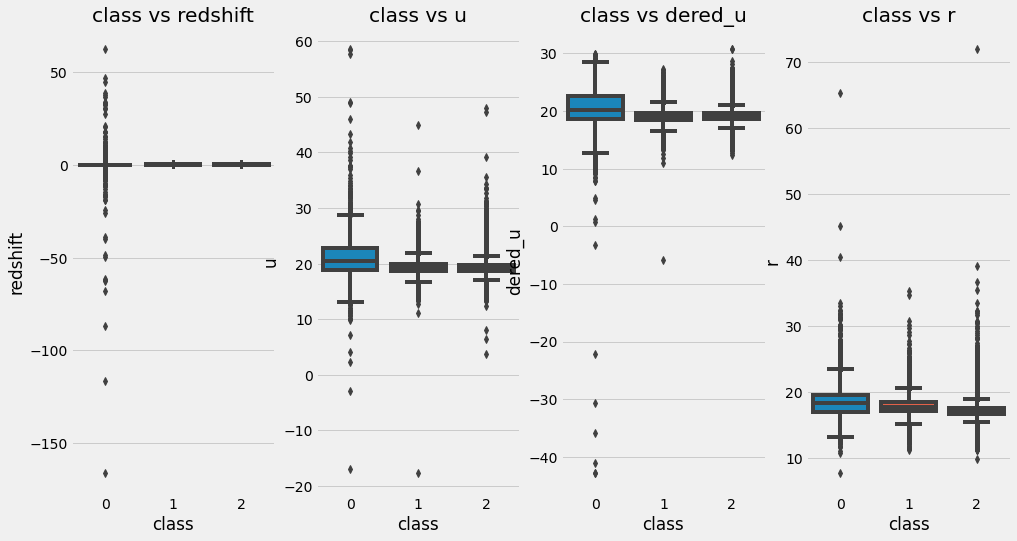

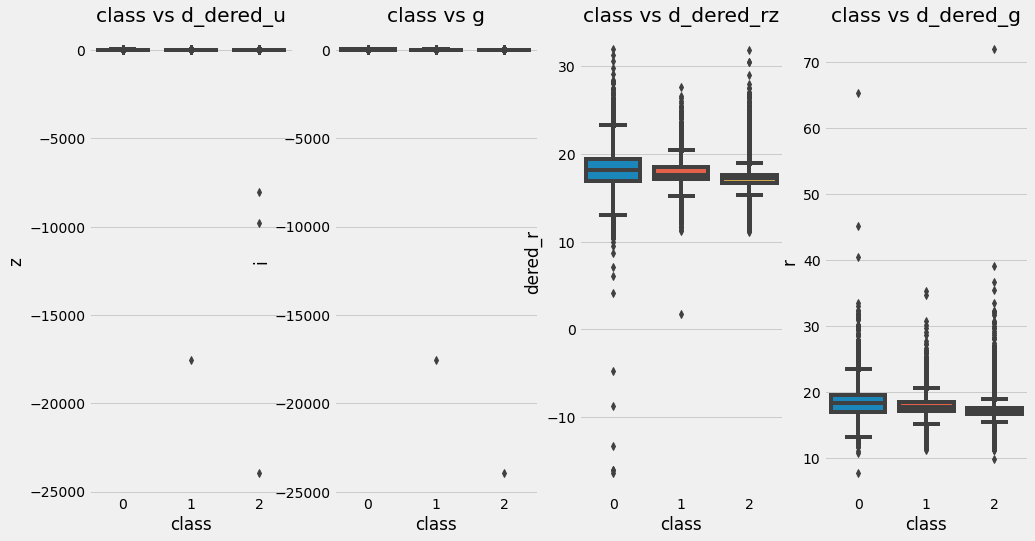

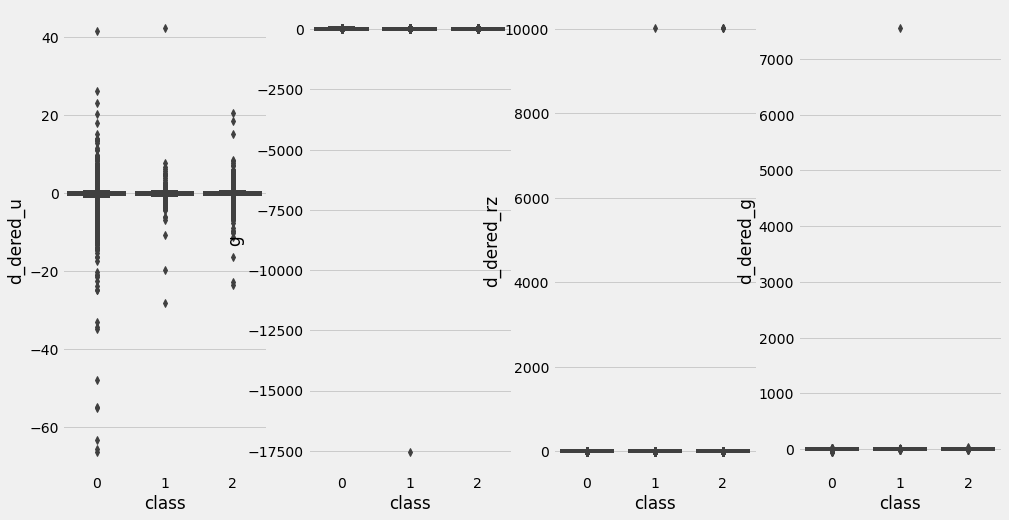

In [15]:
f , axes = plt.subplots(ncols = 4, figsize = (15,8))

sns.boxplot(x = 'class', y = 'redshift', data= train, ax= axes[0])
axes[0].set_title('class vs redshift')
sns.boxplot(x = 'class', y = 'u', data= train, ax= axes[1])
axes[1].set_title('class vs u')
sns.boxplot(x = 'class', y = 'dered_u', data= train, ax= axes[2])
axes[2].set_title('class vs dered_u')
sns.boxplot(x = 'class', y = 'r', data= train, ax= axes[3])
axes[3].set_title('class vs r')

p, axes1 = plt.subplots(ncols = 4, figsize = (15,8))
sns.boxplot(x = 'class', y = 'z', data= train, ax= axes1[0])
axes1[0].set_title('class vs z')
sns.boxplot(x = 'class', y = 'i', data= train, ax= axes1[1])
axes1[1].set_title('class vs i')
sns.boxplot(x = 'class', y = 'dered_r', data= train, ax= axes1[2])
axes1[2].set_title('class vs dered_r')
sns.boxplot(x = 'class', y = 'r', data= train, ax= axes1[3])
axes1[3].set_title('class vs r')

k, axes2 = plt.subplots(ncols = 4, figsize = (15,8))
sns.boxplot(x = 'class', y = 'd_dered_u', data= train, ax= axes2[0])
axes1[0].set_title('class vs d_dered_u')
sns.boxplot(x = 'class', y = 'g', data= train, ax= axes2[1])
axes1[1].set_title('class vs g')
sns.boxplot(x = 'class', y = 'd_dered_rz', data= train, ax= axes2[2])
axes1[2].set_title('class vs d_dered_rz')
sns.boxplot(x = 'class', y = 'd_dered_g', data= train, ax= axes2[3])
axes1[3].set_title('class vs d_dered_g')


<h3> Column 설정하기 </h3> 

In [16]:
target_col = 'class'
pred_col = 'pred'
num_cols = [x for x in train.columns if train[x].dtype in [np.int64, np.float64] and x != target_col]
print(num_cols)

['id', 'u', 'g', 'r', 'i', 'z', 'redshift', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'airmass_u', 'nObserve_log', 'nDetect_log', 'd_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_ig', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz', 'd_obs_det']


cols_to_use 설정하기

In [17]:
num_col = [x for x in train.columns if train[x].dtype in [np.int64, np.float64] and x != target_col and x != 'id']
cols_to_use = ['u', 'g', 'r', 'i', 'z','redshift', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'airmass_u', 'nObserve_log',
 'nDetect_log', 'd_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_ig', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz',
 'd_obs_det']
cols_to_use_small  = ['redshift','dered_u','r','dered_r','u','nObserve','nDetect']
#이 중 정규화를 했으면 좋겠는 열은 g, z, dered_z
#이외로 train에서는 i,dered_g, dered_i에서 Outlier가 있고
# test 에서는 g,z,dered_z
# Redshift의 경우 제일 영향이 많은 Column이므로 섣부른 정규화는 조심히 수행하자
cols_to_scale = ['g','z','dered_z']
num_col


['u',
 'g',
 'r',
 'i',
 'z',
 'redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'airmass_u',
 'nObserve_log',
 'nDetect_log',
 'd_dered_u',
 'd_dered_g',
 'd_dered_r',
 'd_dered_i',
 'd_dered_z',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',
 'd_obs_det']

In [57]:
cols_to_use

['u',
 'g',
 'r',
 'i',
 'z',
 'redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'airmass_u',
 'nObserve_log',
 'nDetect_log',
 'd_dered_u',
 'd_dered_g',
 'd_dered_r',
 'd_dered_i',
 'd_dered_z',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',
 'd_obs_det']

<h4> Class 1, 2만 분류 해보기 </h4>

In [18]:
class01 = train[train['class'] != 0]


<h5>SMALL Classification between class 1, class2

<h5 style='color : green'>//class 1과 2만 비교

In [19]:
#Normal
X01 = class01[cols_to_use]
y01 = class01['class']

seed = 8
test_size = 0.15
#15%는 테스트용, 85%는 학습용
X_train0, X_test0, y_train0, y_test0 = train_test_split(X01,y01, test_size = test_size , random_state = seed)
print(X_train0.shape,X_test0.shape)

(170003, 24) (30001, 24)


In [20]:
from xgboost import XGBClassifier
small_model = XGBClassifier(
                         max_depth = 11,
                         nthread = 8,
                         objective = 'binary:logistic',
                        min_child_wieght = 3,
                         n_estimators =400,
                         learning_rate = 0.15,
                        )
evals = [(X_test0, y_test0)]
#my_model = XGBRegressor(params = params, num_boost_round = nums_round,learning_rate = 0.2)
result= small_model.fit(X_train0, y_train0, early_stopping_rounds=20, eval_set=evals, verbose = True)

[03:07:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_wieght } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.13036
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.12303
[2]	validation_0-error:0.11870
[3]	validation_0-error:0.11700
[4]	validation_0-error:0.11580
[5]	validation_0-error:0.11546
[6]	validation_0-error:0.11383
[7]	validation_0-error:0.11266
[8]	validation_0-error:0.11110
[9]	validation_0-error:0.10990
[10]	validation_0-error:0.10910
[11]	validation_0-error:0.10903
[12]	validation_0-error:0.10803
[13]	validation_0-error:0.10830
[14]	validation_0-error:0.10703
[15]	validation_0-error:0.10743
[16]	validation_0-error:0.10663
[17]	v

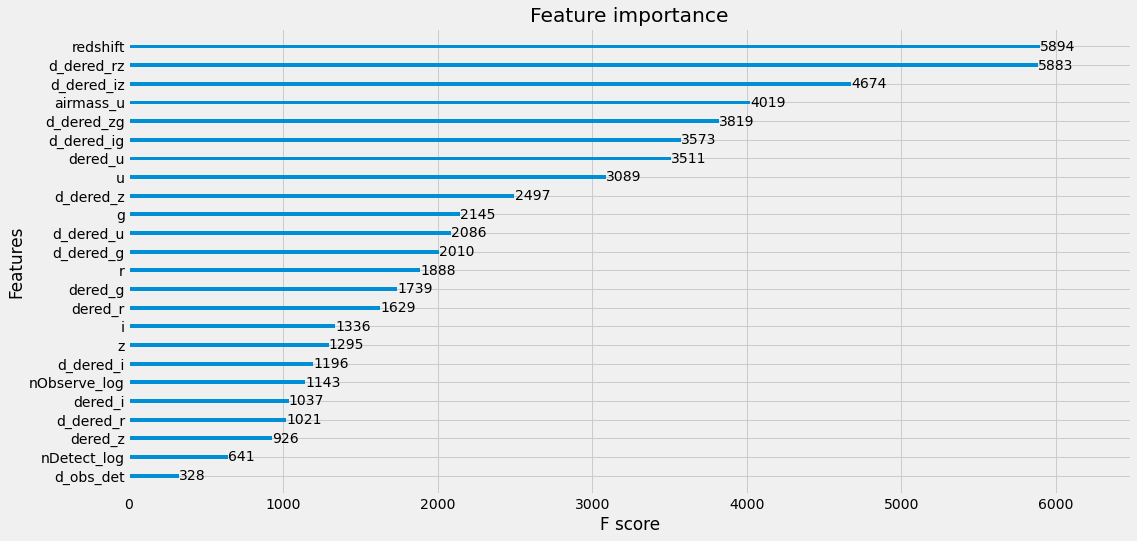

In [21]:
plot_importance(small_model)

In [22]:
y_pred0 = small_model.predict(X_test0)
y_pred0
predictions0 = [round(value) for value in y_pred0]

In [23]:
predictions0

[2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [24]:
accuracy = accuracy_score(y_test0, predictions0)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.89%


해보면 알겠지만, Class 1, 2를 구분하는게 전체 정확도에 큰 영향을 줌

cols_to_scale 분포 보기

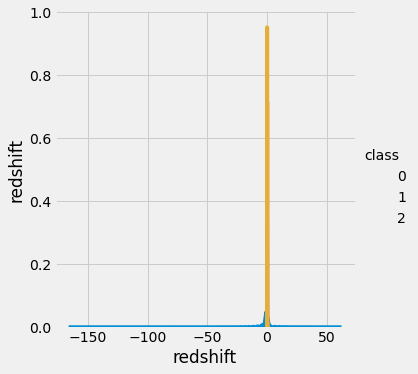

In [25]:
sns.pairplot(train, vars=['redshift'], hue='class', size=5)

<h5 style="color:green">/* 처음 할때는 여기 무시하세요 

<h1> 데이터 정규화 및 Outlier 처리</h1>

cols_to_scale에 정규화를 적용한 cols_scaled와 train_scaled를 생성해 보기

일반적인 정규화 <br>
    1. StandardScaler
    2. MinMaxScaler 최대 최소 스케일링
Outlier가 있을 때
    1. Z-score
    2. Tukey_fences
    3. Robust Scaler
     

<h4>> 내가 접근 해볼 것</h4>
1. Outlier를 아예 Train 에서 제거하고, 모델 학습을 시킨다     --> Model0 <br>
2. Outlier가 포함된 Train 에서 Scaler모델을 적용, 학습시킨다  --> Model1 <br>
3. Outlier를 아예 제거, 정규화(StandardScaler)를 적용해 본다  --> Model2

<h5> 1. Model0 </h5>

In [26]:
train[cols_to_use].describe()

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
count,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,3.2000e+05,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000
mean,19.8524,18.3768,17.7358,17.1742,16.8752,5.8308e-02,19.6289,18.2271,17.6154,17.1523,16.8693,1.1758,1.4861,1.4702,-0.2236,-0.1498,-0.1203,-0.0219,-0.0059,-1.0747,-1.3578,0.7462,0.2831,0.1939
std,1.9455,31.1108,1.4662,52.5615,57.1463,5.7546e-01,1.9236,17.7866,1.4730,25.0758,35.4365,0.1163,0.9061,0.8959,0.6967,13.3675,0.3630,28.0581,28.2757,17.7284,30.6874,35.4207,25.0444,1.0243
min,-17.6875,-17555.3656,7.7314,-23955.8178,-23955.8178,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0001,0.6931,0.6931,-66.3661,-51.2796,-46.9576,-26.3505,-1968.6898,-10017.1270,-10017.2590,-17.7428,-16.6637,-1.0000
25%,18.7242,17.4749,16.8772,16.5239,16.2889,3.5580e-05,18.5636,17.3484,16.7871,16.4530,16.2341,1.0882,0.6931,0.6931,-0.2342,-0.1649,-0.1136,-0.0847,-0.0700,-1.2330,-1.5263,0.3072,0.0844,0.0000
50%,19.4194,18.1405,17.5258,17.1497,16.9176,4.7129e-02,19.2646,18.0224,17.4434,17.0874,16.8694,1.1793,1.0986,1.0986,-0.1342,-0.1014,-0.0701,-0.0523,-0.0405,-0.9160,-1.1169,0.5338,0.2009,0.0000
75%,20.4321,19.0732,18.4281,18.0074,17.7289,9.4597e-02,20.1976,18.8884,18.2911,17.9070,17.6557,1.2275,1.7918,1.7918,-0.0706,-0.0632,-0.0439,-0.0325,-0.0207,-0.6014,-0.6951,0.7146,0.2965,0.0000
max,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,2.0508,3.8067,3.7612,42.2511,7556.3656,16.9807,13956.8178,13956.8178,21.8604,27.7746,10016.8755,10016.5565,40.0000


In [27]:
ids = train
show = ids[(ids['dered_g'] <-1000) | (ids['dered_i'] < -1000) | (ids['dered_z'] <-1000) & (ids['class'] == 0) ]
train_model0 = ids[(ids['dered_g'] >-1000) & (ids['dered_i'] > -1000) & (ids['dered_z'] >-1000)]
train_model0

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,class,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
0,0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,1.1898,0,2.9444,2.9444,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,0
1,1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1.2533,1,0.6931,0.6931,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,0
2,2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0225,0,1.0986,1.0986,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,0
3,3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.2054,0,1.6094,1.3863,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,1
4,4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,1.1939,0,2.6391,2.5649,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,319995,18.3656,17.2409,16.7739,16.4850,16.3404,5.1988e-02,18.1328,17.0406,16.6374,16.3861,16.2874,1.0930,2,1.0986,1.0986,-0.2328,-0.2002,-0.1365,-0.0989,-0.0530,-0.6546,-0.7532,0.3500,0.0986,0
319996,319996,18.6856,17.6658,17.1904,16.8169,16.6367,8.7261e-02,18.5207,17.5131,17.0871,16.7436,16.6017,1.0517,1,1.0986,1.0986,-0.1649,-0.1527,-0.1033,-0.0732,-0.0350,-0.7695,-0.9114,0.4854,0.1419,0
319997,319997,21.1890,18.4234,17.2956,16.9011,16.6841,-1.0148e-05,20.9890,18.3076,17.2152,16.8403,16.6355,1.1933,0,3.4657,3.4340,-0.2000,-0.1158,-0.0804,-0.0608,-0.0486,-1.4673,-1.6721,0.5796,0.2048,1
319998,319998,18.8472,17.3186,16.5057,16.1806,15.9116,-4.5209e-05,16.3900,15.4058,15.1823,15.1969,15.1793,1.1725,0,0.6931,0.6931,-2.4572,-1.9128,-1.3234,-0.9836,-0.7323,-0.2089,-0.2264,0.0029,0.0176,0


In [28]:
train_model0.describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,class,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
count,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,3.2000e+05,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000
mean,159999.9526,19.8524,18.4318,17.7358,17.3041,17.0608,5.8307e-02,19.6289,18.2584,17.6154,17.2149,16.9945,1.1758,1.1163,1.4861,1.4702,-0.2236,-0.1734,-0.1203,-0.0891,-0.0663,-1.0434,-1.2639,0.6210,0.2205,0.1939
std,92376.5460,1.9456,1.6612,1.4663,1.3226,1.3370,5.7546e-01,1.9236,1.6681,1.4730,1.3294,1.3263,0.1163,0.9235,0.9061,0.8960,0.6967,0.4989,0.3630,0.2960,0.3156,0.8898,1.1140,0.7714,0.4587,1.0243
min,0.0000,-17.6875,-12.4441,7.7314,-23.9024,-9.2548,-1.6605e+02,-42.8375,-30.3208,-16.3802,-8.9412,-3.7059,1.0001,0.0000,0.6931,0.6931,-66.3661,-51.2796,-46.9576,-26.3505,-30.5841,-15.0278,-17.2340,-17.7428,-16.6637,-1.0000
25%,79999.7500,18.7241,17.4749,16.8772,16.5239,16.2889,3.5578e-05,18.5636,17.3484,16.7871,16.4531,16.2341,1.0882,0.0000,0.6931,0.6931,-0.2342,-0.1649,-0.1136,-0.0847,-0.0700,-1.2330,-1.5262,0.3072,0.0844,0.0000
50%,160000.5000,19.4194,18.1405,17.5258,17.1497,16.9176,4.7128e-02,19.2646,18.0224,17.4434,17.0874,16.8694,1.1793,1.0000,1.0986,1.0986,-0.1342,-0.1014,-0.0701,-0.0523,-0.0405,-0.9160,-1.1169,0.5338,0.2009,0.0000
75%,240000.2500,20.4321,19.0732,18.4281,18.0074,17.7289,9.4597e-02,20.1976,18.8885,18.2911,17.9070,17.6557,1.2275,2.0000,1.7918,1.7918,-0.0706,-0.0632,-0.0439,-0.0325,-0.0207,-0.6014,-0.6951,0.7146,0.2965,0.0000
max,319999.0000,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,2.0508,2.0000,3.8067,3.7612,42.2511,37.5039,16.9807,48.3583,33.8940,21.8604,27.7746,16.3026,16.4438,40.0000


<h4> Xgboost </h4>

<h4> Train Split </h4>

In [29]:
from xgboost import XGBClassifier
#Normal
X = train[cols_to_use]
y = train['class']

seed = 8
test_size = 0.15
#15%는 테스트용, 85%는 학습용
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size , random_state = seed)
print(X_train.shape,X_test.shape)

(272000, 24) (48000, 24)


In [30]:
testX = test[cols_to_use]
testX

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
0,19.1431,18.0172,17.4733,17.1144,16.9263,1.2130e-01,19.0750,17.9550,17.4308,17.0838,16.9087,1.1563,0.6931,0.6931,-0.0681,-0.0622,-0.0424,-0.0306,-0.0176,-0.8711,-1.0462,0.5221,0.1751,0
1,18.7409,17.1705,16.3691,15.9865,15.7307,-6.6907e-05,15.0703,14.3098,14.3901,14.5160,14.6372,1.0076,1.0986,1.0986,-3.6706,-2.8607,-1.9790,-1.4705,-1.0935,0.2062,0.3274,-0.2470,-0.1212,0
2,19.2980,17.8803,17.2221,16.8096,16.6352,1.1001e-01,19.1004,17.7726,17.1460,16.7497,16.5689,1.3809,0.6931,0.6931,-0.1977,-0.1077,-0.0761,-0.0599,-0.0664,-1.0230,-1.2037,0.5771,0.1808,0
3,18.0775,17.1569,16.9041,16.8118,16.7955,2.9697e-05,17.9729,17.0735,16.8470,16.7700,16.7668,1.1408,0.6931,0.6931,-0.1045,-0.0834,-0.0572,-0.0418,-0.0288,-0.3036,-0.3068,0.0802,0.0032,0
4,17.8325,16.7646,16.2135,15.8722,15.6621,6.8471e-02,17.7545,16.6794,16.1563,15.8315,15.6433,1.1110,1.0986,1.0986,-0.0780,-0.0852,-0.0572,-0.0407,-0.0187,-0.8480,-1.0361,0.5129,0.1881,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,1.1858,2.8904,2.8904,-0.3372,-0.2684,-0.1848,-0.1364,-0.0957,-0.4072,-0.4263,0.1190,0.0191,0
79996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,1.2850,2.1972,1.6094,-0.1235,-0.0884,-0.0636,-0.0542,-0.0631,0.3108,0.1428,-0.2376,0.1680,4
79997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1.1885,0.6931,0.6931,-0.4855,-0.3657,-0.2558,-0.1935,-0.1618,0.1289,0.1647,-0.1353,-0.0357,0
79998,18.8997,17.6009,17.1329,16.8223,16.5946,4.2817e-02,18.7715,17.4880,17.0557,16.7660,16.5585,1.1804,2.8904,2.8904,-0.1282,-0.1129,-0.0772,-0.0564,-0.0361,-0.7220,-0.9295,0.4972,0.2075,0


In [106]:
#최적 파라미터 찾는 부분
params = {
    "objective": "multi:softmax",
    "n_estimators": 2000,
    "random_state": seed,
    "n_jobs": -1
}

space = {
    'max_depth' : hp.choice('max_depth', range(5, 18, 1)),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.1),
    
    'min_child_weight' : hp.quniform('min_child_weight', 5, 20, 2),
    'subsample' : hp.quniform('subsample', 0.8, 1, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1.0, 0.1)
    
}


In [107]:
def objective(hyperparams):
    model = XGBClassifier(**params, **hyperparams)
    model.fit(X=X_train, y=y_train,
              eval_set=[(X_test, y_test)],
              eval_metric="merror",
              early_stopping_rounds=10,
              verbose=False)
    pred = model.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    #change the metric if you like
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

job exception: type object got multiple values for keyword argument 'max_depth'



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]


TypeError: type object got multiple values for keyword argument 'max_depth'

In [71]:
params.update(hyperparams)
print(params)

{'objective': 'multi:softmax', 'n_estimators': 1000, 'random_state': 8, 'n_jobs': -1, 'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05057535652410193, 'max_depth': 12, 'min_child_weight': 10.0, 'subsample': 0.9}


<h4>기다리던 학습</h4>

In [ ]:

my_model = XGBClassifier(
                         max_depth = 11,
                         nthread = 8,
                         objective = 'multi:softmax',
                         n_estimators =1000,
                        min_child_weight =3,
                        subsample =.8,
                         learning_rate = 0.15,
                        )
evals = [(X_test, y_test)]
#my_model = XGBRegressor(params = params, num_boost_round = nums_round,learning_rate = 0.2)
result= my_model.fit(X_train,y_train, early_stopping_rounds=30, eval_set=evals, verbose = True)

In [ ]:
y_pred = my_model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.5f%%" % (accuracy * 100.0))

In [72]:
my_model1 = XGBClassifier(**params)
evals = [(X_test, y_test)]
#my_model = XGBRegressor(params = params, num_boost_round = nums_round,learning_rate = 0.2)
result= my_model1.fit(X_train,y_train, early_stopping_rounds=30, eval_set=evals, verbose = True)

[0]	validation_0-merror:0.07865
Will train until validation_0-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.07654
[2]	validation_0-merror:0.07548
[3]	validation_0-merror:0.07483
[4]	validation_0-merror:0.07352
[5]	validation_0-merror:0.07292
[6]	validation_0-merror:0.07244
[7]	validation_0-merror:0.07269
[8]	validation_0-merror:0.07292
[9]	validation_0-merror:0.07281
[10]	validation_0-merror:0.07231
[11]	validation_0-merror:0.07223
[12]	validation_0-merror:0.07198
[13]	validation_0-merror:0.07190
[14]	validation_0-merror:0.07171
[15]	validation_0-merror:0.07187
[16]	validation_0-merror:0.07175
[17]	validation_0-merror:0.07162
[18]	validation_0-merror:0.07104
[19]	validation_0-merror:0.07115
[20]	validation_0-merror:0.07098
[21]	validation_0-merror:0.07104
[22]	validation_0-merror:0.07062
[23]	validation_0-merror:0.07035
[24]	validation_0-merror:0.07031
[25]	validation_0-merror:0.07046
[26]	validation_0-merror:0.07023
[27]	validation_0-merror:0.06981
[28]	validation_0-m

[243]	validation_0-merror:0.06348
[244]	validation_0-merror:0.06348
[245]	validation_0-merror:0.06348
[246]	validation_0-merror:0.06342
[247]	validation_0-merror:0.06342
[248]	validation_0-merror:0.06356
[249]	validation_0-merror:0.06360
[250]	validation_0-merror:0.06367
[251]	validation_0-merror:0.06369
[252]	validation_0-merror:0.06365
[253]	validation_0-merror:0.06367
[254]	validation_0-merror:0.06360
[255]	validation_0-merror:0.06360
[256]	validation_0-merror:0.06360
[257]	validation_0-merror:0.06356
[258]	validation_0-merror:0.06358
[259]	validation_0-merror:0.06358
[260]	validation_0-merror:0.06363
[261]	validation_0-merror:0.06371
[262]	validation_0-merror:0.06367
[263]	validation_0-merror:0.06367
[264]	validation_0-merror:0.06369
[265]	validation_0-merror:0.06356
[266]	validation_0-merror:0.06358
[267]	validation_0-merror:0.06356
[268]	validation_0-merror:0.06358
[269]	validation_0-merror:0.06354
[270]	validation_0-merror:0.06352
[271]	validation_0-merror:0.06352
[272]	validati

In [81]:
y_pred = my_model1.predict(X_test)
predictions = [round(value) for value in y_pred]

In [82]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.5f%%" % (accuracy * 100.0))

Accuracy: 93.65833%


In [83]:
predictions

[2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 2,
 1,
 1,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 0,
 2,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 1,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,


In [77]:
best_params = {'objective': 'multi:softmax', 'n_estimators': 1000, 'random_state': 8, 'n_jobs': -1, 'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05057535652410193, 'max_depth': 12, 'min_child_weight': 10.0, 'subsample': 0.9}

In [87]:
Y_pred = my_model1.predict(testX)
predictions = [int(round(value)) for value in Y_pred]
predictions

[2,
 0,
 2,
 0,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 0,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 1,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 2,


In [92]:
df = feature

In [94]:
y = df[target_col].values[:320000]
trn = df[cols_to_use].iloc[:320000].values
tst = df[cols_to_use].iloc[320000:].values
feature_name = df[cols_to_use].columns.tolist()

In [97]:
n_fold = 5
n_class = 3
cv = KFold(n_splits = n_fold, shuffle = True, random_state = 1)
cvs = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = 1)

In [100]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst1 = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    xgb_clf1 = XGBClassifier(**params)
    xgb_clf1.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            early_stopping_rounds=80)
    p_val[i_val, :] = xgb_clf1.predict_proba(trn[i_val])
    p_tst1 += xgb_clf1.predict_proba(tst) / n_fold

training model for CV #1
[0]	validation_0-merror:0.08206
Will train until validation_0-merror hasn't improved in 80 rounds.
[1]	validation_0-merror:0.07941
[2]	validation_0-merror:0.07873
[3]	validation_0-merror:0.07805
[4]	validation_0-merror:0.07727
[5]	validation_0-merror:0.07658
[6]	validation_0-merror:0.07614
[7]	validation_0-merror:0.07556
[8]	validation_0-merror:0.07567
[9]	validation_0-merror:0.07516
[10]	validation_0-merror:0.07498
[11]	validation_0-merror:0.07505
[12]	validation_0-merror:0.07502
[13]	validation_0-merror:0.07464
[14]	validation_0-merror:0.07442
[15]	validation_0-merror:0.07430
[16]	validation_0-merror:0.07422
[17]	validation_0-merror:0.07400
[18]	validation_0-merror:0.07386
[19]	validation_0-merror:0.07373
[20]	validation_0-merror:0.07369
[21]	validation_0-merror:0.07337
[22]	validation_0-merror:0.07339
[23]	validation_0-merror:0.07298
[24]	validation_0-merror:0.07284
[25]	validation_0-merror:0.07269
[26]	validation_0-merror:0.07241
[27]	validation_0-merror:0.

[242]	validation_0-merror:0.06680
[243]	validation_0-merror:0.06678
Stopping. Best iteration:
[163]	validation_0-merror:0.06675

training model for CV #2
[0]	validation_0-merror:0.07953
Will train until validation_0-merror hasn't improved in 80 rounds.
[1]	validation_0-merror:0.07689
[2]	validation_0-merror:0.07581
[3]	validation_0-merror:0.07537
[4]	validation_0-merror:0.07514
[5]	validation_0-merror:0.07431
[6]	validation_0-merror:0.07445
[7]	validation_0-merror:0.07400
[8]	validation_0-merror:0.07352
[9]	validation_0-merror:0.07384
[10]	validation_0-merror:0.07366
[11]	validation_0-merror:0.07323
[12]	validation_0-merror:0.07294
[13]	validation_0-merror:0.07291
[14]	validation_0-merror:0.07277
[15]	validation_0-merror:0.07264
[16]	validation_0-merror:0.07231
[17]	validation_0-merror:0.07242
[18]	validation_0-merror:0.07223
[19]	validation_0-merror:0.07209
[20]	validation_0-merror:0.07214
[21]	validation_0-merror:0.07198
[22]	validation_0-merror:0.07178
[23]	validation_0-merror:0.071

[238]	validation_0-merror:0.06522
[239]	validation_0-merror:0.06517
[240]	validation_0-merror:0.06513
[241]	validation_0-merror:0.06516
[242]	validation_0-merror:0.06511
[243]	validation_0-merror:0.06508
[244]	validation_0-merror:0.06519
[245]	validation_0-merror:0.06527
[246]	validation_0-merror:0.06530
[247]	validation_0-merror:0.06533
[248]	validation_0-merror:0.06528
[249]	validation_0-merror:0.06533
[250]	validation_0-merror:0.06539
[251]	validation_0-merror:0.06538
[252]	validation_0-merror:0.06528
[253]	validation_0-merror:0.06523
[254]	validation_0-merror:0.06523
[255]	validation_0-merror:0.06527
[256]	validation_0-merror:0.06527
[257]	validation_0-merror:0.06533
[258]	validation_0-merror:0.06528
[259]	validation_0-merror:0.06528
[260]	validation_0-merror:0.06531
[261]	validation_0-merror:0.06530
[262]	validation_0-merror:0.06531
[263]	validation_0-merror:0.06528
[264]	validation_0-merror:0.06516
[265]	validation_0-merror:0.06519
[266]	validation_0-merror:0.06517
[267]	validati

[71]	validation_0-merror:0.06745
[72]	validation_0-merror:0.06752
[73]	validation_0-merror:0.06759
[74]	validation_0-merror:0.06764
[75]	validation_0-merror:0.06753
[76]	validation_0-merror:0.06752
[77]	validation_0-merror:0.06738
[78]	validation_0-merror:0.06742
[79]	validation_0-merror:0.06738
[80]	validation_0-merror:0.06727
[81]	validation_0-merror:0.06713
[82]	validation_0-merror:0.06711
[83]	validation_0-merror:0.06725
[84]	validation_0-merror:0.06714
[85]	validation_0-merror:0.06703
[86]	validation_0-merror:0.06700
[87]	validation_0-merror:0.06703
[88]	validation_0-merror:0.06702
[89]	validation_0-merror:0.06691
[90]	validation_0-merror:0.06684
[91]	validation_0-merror:0.06684
[92]	validation_0-merror:0.06683
[93]	validation_0-merror:0.06678
[94]	validation_0-merror:0.06667
[95]	validation_0-merror:0.06667
[96]	validation_0-merror:0.06670
[97]	validation_0-merror:0.06666
[98]	validation_0-merror:0.06673
[99]	validation_0-merror:0.06661
[100]	validation_0-merror:0.06655
[101]	val

[313]	validation_0-merror:0.06452
[314]	validation_0-merror:0.06456
[315]	validation_0-merror:0.06459
[316]	validation_0-merror:0.06447
[317]	validation_0-merror:0.06441
[318]	validation_0-merror:0.06442
[319]	validation_0-merror:0.06439
[320]	validation_0-merror:0.06436
[321]	validation_0-merror:0.06438
[322]	validation_0-merror:0.06441
[323]	validation_0-merror:0.06434
[324]	validation_0-merror:0.06439
[325]	validation_0-merror:0.06442
[326]	validation_0-merror:0.06436
[327]	validation_0-merror:0.06439
[328]	validation_0-merror:0.06441
[329]	validation_0-merror:0.06445
[330]	validation_0-merror:0.06445
[331]	validation_0-merror:0.06445
[332]	validation_0-merror:0.06445
[333]	validation_0-merror:0.06458
[334]	validation_0-merror:0.06452
[335]	validation_0-merror:0.06452
[336]	validation_0-merror:0.06450
[337]	validation_0-merror:0.06458
[338]	validation_0-merror:0.06458
[339]	validation_0-merror:0.06458
[340]	validation_0-merror:0.06464
[341]	validation_0-merror:0.06466
[342]	validati

[179]	validation_0-merror:0.06745
[180]	validation_0-merror:0.06752
[181]	validation_0-merror:0.06755
[182]	validation_0-merror:0.06755
[183]	validation_0-merror:0.06755
[184]	validation_0-merror:0.06756
[185]	validation_0-merror:0.06763
[186]	validation_0-merror:0.06772
[187]	validation_0-merror:0.06770
[188]	validation_0-merror:0.06770
[189]	validation_0-merror:0.06763
[190]	validation_0-merror:0.06763
[191]	validation_0-merror:0.06761
[192]	validation_0-merror:0.06756
[193]	validation_0-merror:0.06755
[194]	validation_0-merror:0.06755
[195]	validation_0-merror:0.06752
[196]	validation_0-merror:0.06752
[197]	validation_0-merror:0.06747
[198]	validation_0-merror:0.06747
[199]	validation_0-merror:0.06745
[200]	validation_0-merror:0.06742
[201]	validation_0-merror:0.06739
[202]	validation_0-merror:0.06734
[203]	validation_0-merror:0.06738
[204]	validation_0-merror:0.06741
[205]	validation_0-merror:0.06738
[206]	validation_0-merror:0.06741
[207]	validation_0-merror:0.06730
[208]	validati

[14]	validation_0-merror:0.07534
[15]	validation_0-merror:0.07494
[16]	validation_0-merror:0.07503
[17]	validation_0-merror:0.07498
[18]	validation_0-merror:0.07456
[19]	validation_0-merror:0.07433
[20]	validation_0-merror:0.07425
[21]	validation_0-merror:0.07408
[22]	validation_0-merror:0.07395
[23]	validation_0-merror:0.07389
[24]	validation_0-merror:0.07364
[25]	validation_0-merror:0.07362
[26]	validation_0-merror:0.07341
[27]	validation_0-merror:0.07302
[28]	validation_0-merror:0.07311
[29]	validation_0-merror:0.07314
[30]	validation_0-merror:0.07291
[31]	validation_0-merror:0.07287
[32]	validation_0-merror:0.07267
[33]	validation_0-merror:0.07278
[34]	validation_0-merror:0.07278
[35]	validation_0-merror:0.07258
[36]	validation_0-merror:0.07234
[37]	validation_0-merror:0.07223
[38]	validation_0-merror:0.07208
[39]	validation_0-merror:0.07214
[40]	validation_0-merror:0.07192
[41]	validation_0-merror:0.07211
[42]	validation_0-merror:0.07189
[43]	validation_0-merror:0.07197
[44]	valid

[258]	validation_0-merror:0.06775
[259]	validation_0-merror:0.06772
[260]	validation_0-merror:0.06781
[261]	validation_0-merror:0.06791
[262]	validation_0-merror:0.06791
[263]	validation_0-merror:0.06788
[264]	validation_0-merror:0.06778
[265]	validation_0-merror:0.06770
[266]	validation_0-merror:0.06769
[267]	validation_0-merror:0.06766
[268]	validation_0-merror:0.06766
[269]	validation_0-merror:0.06767
[270]	validation_0-merror:0.06758
[271]	validation_0-merror:0.06750
[272]	validation_0-merror:0.06750
[273]	validation_0-merror:0.06752
[274]	validation_0-merror:0.06755
[275]	validation_0-merror:0.06753
[276]	validation_0-merror:0.06753
[277]	validation_0-merror:0.06747
[278]	validation_0-merror:0.06742
[279]	validation_0-merror:0.06753
[280]	validation_0-merror:0.06748
[281]	validation_0-merror:0.06750
[282]	validation_0-merror:0.06767
[283]	validation_0-merror:0.06764
[284]	validation_0-merror:0.06759
[285]	validation_0-merror:0.06755
[286]	validation_0-merror:0.06752
[287]	validati

[499]	validation_0-merror:0.06702
[500]	validation_0-merror:0.06700
[501]	validation_0-merror:0.06695
[502]	validation_0-merror:0.06705
[503]	validation_0-merror:0.06694
[504]	validation_0-merror:0.06700
[505]	validation_0-merror:0.06700
[506]	validation_0-merror:0.06703
[507]	validation_0-merror:0.06705
[508]	validation_0-merror:0.06713
[509]	validation_0-merror:0.06716
[510]	validation_0-merror:0.06719
[511]	validation_0-merror:0.06714
[512]	validation_0-merror:0.06711
[513]	validation_0-merror:0.06714
[514]	validation_0-merror:0.06714
[515]	validation_0-merror:0.06728
[516]	validation_0-merror:0.06728
[517]	validation_0-merror:0.06727
[518]	validation_0-merror:0.06727
[519]	validation_0-merror:0.06720
[520]	validation_0-merror:0.06720
[521]	validation_0-merror:0.06713
[522]	validation_0-merror:0.06719
[523]	validation_0-merror:0.06720
[524]	validation_0-merror:0.06723
[525]	validation_0-merror:0.06727
[526]	validation_0-merror:0.06720
[527]	validation_0-merror:0.06725
[528]	validati

In [101]:
print(f'{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')

93.4194%


In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst2 = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cvs.split(trn, y), 1):
    print(f'training model for CV #{i}')
    xgb_clf2 = XGBClassifier(**params)
    xgb_clf2.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            early_stopping_rounds=30)
    p_val[i_val, :] = xgb_clf2.predict_proba(trn[i_val])
    p_tst2 += xgb_clf2.predict_proba(tst) / n_fold

In [ ]:
print(f'{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')

In [88]:
submission['class'] = predictions

In [89]:
submission.to_csv("xgboost8515Hyperopt_93,65.csv",index=False, encoding='utf-8-sig')

<h5 style = "color:green">/*교차검증Cross Validation, 건드리지 않는게 좋음</h5>

In [ ]:
cv = KFold(5, shuffle=True, random_state=0)

In [ ]:
cross_val_score(my_model, X, y, scoring='accuracy', cv=cv)

<h5 style = "color:green">*/

In [ ]:
from xgboost import plot_tree
plot_tree(my_model)

In [ ]:
import graphviz
dot_data = export_graphviz(my_model, out_file =None,
                          feature_names = cols_to_use,
                           filled = True,
                           rounded = True,
                           special_characters = True
                          )

graph = graphviz.Source(dot_data)
graph

In [ ]:
pred_probs = my_model.predict(X_test)
pred_probs

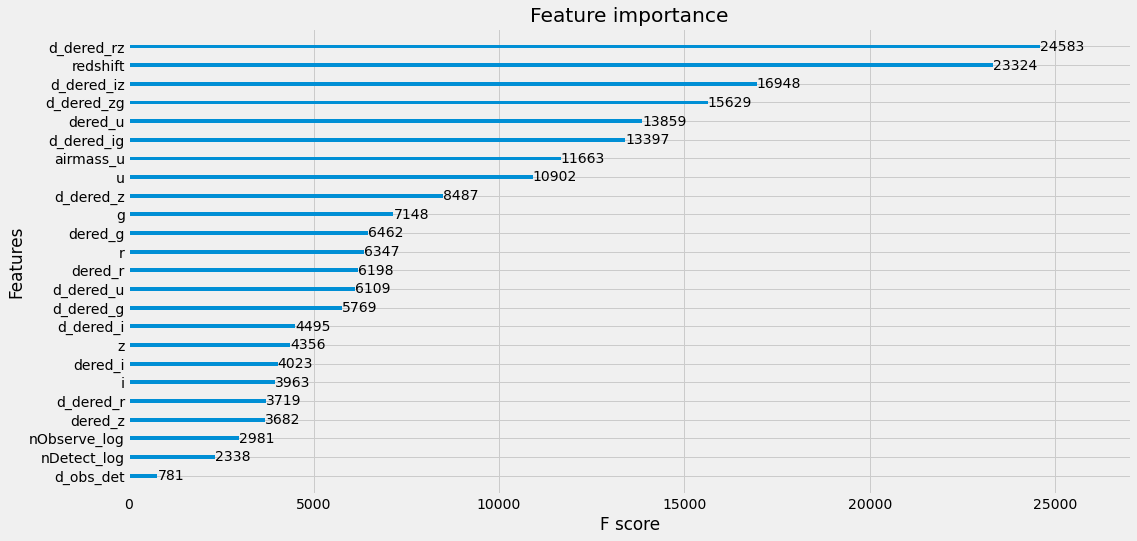

In [103]:
plot_importance(my_model1)

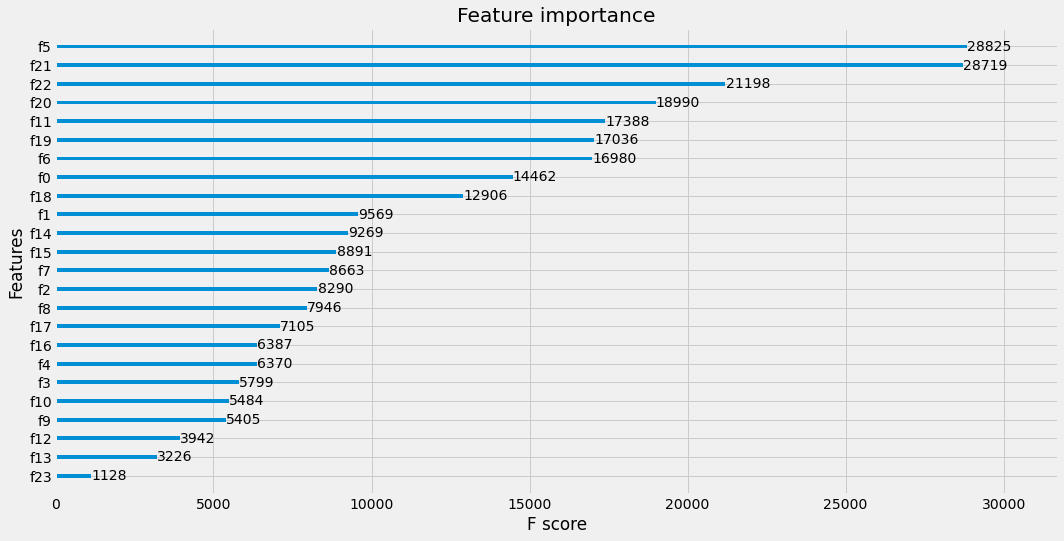

In [105]:
plot_importance(xgb_clf1)

In [ ]:
y_pred = my_model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [45]:
mean_squared_error(y_test, y_pred)

0.0659375

In [46]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.5f%%" % (accuracy * 100.0))

Accuracy: 93.58125%


In [54]:
predictions.shape

AttributeError: 'list' object has no attribute 'shape'

In [55]:
# final result
submission['class'] = predictions
submission.to_csv("8515XGB_----.csv",index=False, encoding='utf-8-sig')

ValueError: Length of values does not match length of index